# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import heapq
from math import sqrt
import time
import pandas as pd

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35060\3399358572.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35060\3399358572.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


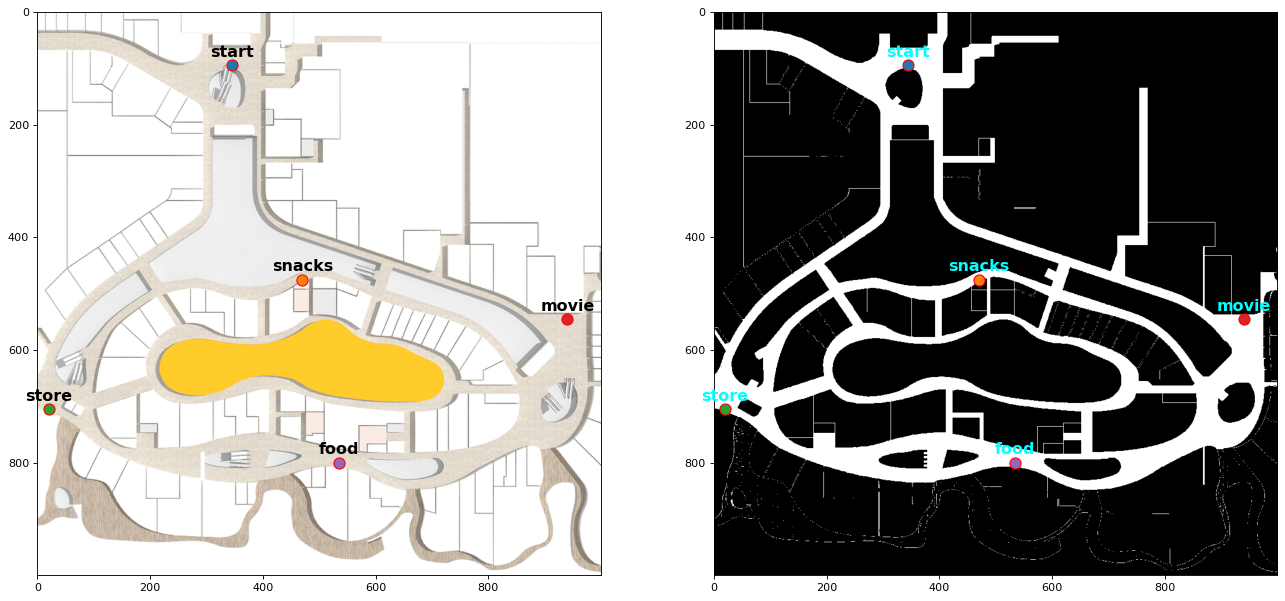

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
# import ipdb
# ipdb.set_trace()

print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  (345, 95),    # Start from the level 2 Escalator
             'snacks': (470, 475),   # Garrett Popcorn
             'store':  (20, 705),    # DJI Store
             'movie':  (940, 545),   # Golden Village
             'food':   (535, 800),   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

Shortest path from start to snacks: 28.70 meters
Shortest path from start to store: 32.54 meters
Shortest path from start to movie: 36.36 meters
Shortest path from start to food: 47.21 meters
Shortest path from snacks to store: 24.32 meters
Shortest path from snacks to movie: 26.07 meters
Shortest path from snacks to food: 27.08 meters
Shortest path from store to movie: 50.77 meters
Shortest path from store to food: 22.99 meters
Shortest path from movie to food: 40.73 meters

Distance Matrix Between Key Locations (in meters):
          start   snacks    store    movie     food
start    0.0000  28.7024  32.5448  36.3632  47.2072
snacks  28.7024   0.0000  24.3240  26.0724  27.0820
store   32.5448  24.3240   0.0000  50.7664  22.9936
movie   36.3632  26.0724  50.7664   0.0000  40.7252
food    47.2072  27.0820  22.9936  40.7252   0.0000


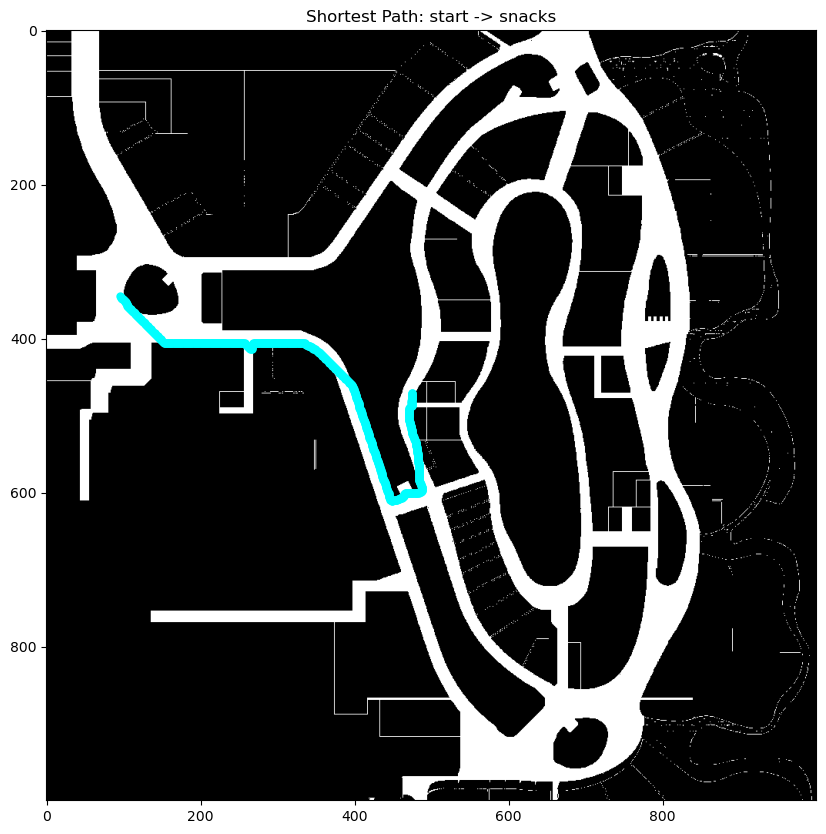


Detailed Performance Metrics for the path from start to snacks:
Planned Path (list of coordinates):
[(345, 95), (346, 96), (347, 97), (348, 98), (349, 99), (350, 100), (351, 101), (352, 102), (353, 103), (354, 103), (355, 104), (356, 104), (357, 104), (358, 105), (359, 106), (360, 107), (361, 108), (362, 109), (363, 110), (364, 111), (365, 112), (366, 113), (367, 114), (368, 115), (369, 116), (370, 117), (371, 118), (372, 119), (373, 120), (374, 121), (375, 122), (376, 123), (377, 124), (378, 125), (379, 126), (380, 127), (381, 128), (382, 129), (383, 130), (384, 131), (385, 132), (386, 133), (387, 134), (388, 135), (389, 136), (390, 137), (391, 138), (392, 139), (393, 140), (394, 141), (395, 142), (396, 143), (397, 144), (398, 145), (399, 146), (400, 147), (401, 148), (402, 149), (403, 150), (404, 151), (405, 152), (405, 153), (405, 154), (405, 155), (405, 156), (405, 157), (405, 158), (405, 159), (405, 160), (405, 161), (405, 162), (405, 163), (405, 164), (405, 165), (405, 166), (40

In [5]:

# ----------------------------
# 1. Define the A* Algorithm Function
# ----------------------------

def heuristic(a, b):
    """Heuristic function using Euclidean distance."""
    return sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def a_star(grid, start, goal):
    """
    A* path planning algorithm.
    
    Returns a dictionary containing:
      - 'path': The planned path (list of coordinates from start to goal)
      - 'total_distance': Total travel distance in meters
      - 'visited_cells': List of all grid cells visited during the search
      - 'run_time': Total run time of the algorithm (in seconds)
      - 'open_nodes': Number of nodes remaining in the open list at termination
      - 'closed_nodes': Number of nodes in the closed list (expanded nodes)
    """
    # 8-connected neighbors (8 directions)
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    
    # Priority queue (min-heap) storing tuples (f, g, node)
    open_list = []
    heapq.heappush(open_list, (heuristic(start, goal), 0, start))
    
    # Dictionary to reconstruct the path
    came_from = {}
    
    # g_score: cost from start to the current node
    g_score = {start: 0}
    
    # Closed list to track visited nodes
    closed_list = set()
    
    # Record all visited grid cells for performance analysis
    visited_cells = []
    
    # Start timer for run time measurement
    start_time = time.time()
    
    while open_list:
        # Pop the node with the smallest f = g + h value
        _, current_g, current = heapq.heappop(open_list)
        
        # Check if goal is reached
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            
            # Calculate total travel distance (grid steps scaled by MAP_RES)
            total_distance = 0
            for i in range(1, len(path)):
                dx = abs(path[i][0] - path[i-1][0])
                dy = abs(path[i][1] - path[i-1][1])
                # Diagonal step: cost 0.282, Orthogonal step: cost 0.2 (in "steps")
                total_distance += 0.282 if dx != 0 and dy != 0 else 0.2
            total_distance *= MAP_RES  # Convert to meters
            
            run_time = time.time() - start_time
            return {
                'path': path,
                'total_distance': total_distance,
                'visited_cells': visited_cells,
                'run_time': run_time,
                'open_nodes': len(open_list),
                'closed_nodes': len(closed_list)
            }
        
        closed_list.add(current)
        visited_cells.append(current)
        
        # Expand neighbors
        for dx, dy in neighbors:
            neighbor = (current[0] + dx, current[1] + dy)
            # Check if neighbor is within grid bounds and is free
            if (0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]
                    and grid[neighbor[0], neighbor[1]] == 255):
                if neighbor in closed_list:
                    continue
                tentative_g = current_g + (0.282 if dx != 0 and dy != 0 else 0.2)
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f = tentative_g + heuristic(neighbor, goal)
                    heapq.heappush(open_list, (f, tentative_g, neighbor))
                    
    return None  # Return None if no path is found

# Function to plot the planned path on the grid map
def plot_path(path, grid, title="A* Planned Path"):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray')
    path_x = [p[1] for p in path]
    path_y = [p[0] for p in path]
    plt.plot(path_x, path_y, marker='o', color='cyan', markersize=5)
    plt.title(title)
    plt.show()

# ----------------------------
# 2. Compute Shortest Paths Between All Key Locations
# ----------------------------

location_keys = list(locations.keys())
# Dictionary to store the path and performance metrics between each pair
shortest_paths = {}

# Compute the shortest path for every pair of key locations
for i in range(len(location_keys)):
    for j in range(i+1, len(location_keys)):
        loc_from = location_keys[i]
        loc_to = location_keys[j]
        start_loc = locations[loc_from]
        goal_loc = locations[loc_to]
        
        result = a_star(grid_map, start_loc, goal_loc)
        if result is not None:
            shortest_paths[(loc_from, loc_to)] = result
            print(f"Shortest path from {loc_from} to {loc_to}: {result['total_distance']:.2f} meters")
            # Optionally, plot each path:
            # plot_path(result['path'], grid_map, title=f"{loc_from} -> {loc_to}")
        else:
            print(f"No path found from {loc_from} to {loc_to}.")

# ----------------------------
# 3. Build and Display the Distance Matrix
# ----------------------------

# Create a distance matrix with key locations as both rows and columns
dist_matrix = pd.DataFrame(np.zeros((len(location_keys), len(location_keys))),
                           index=location_keys, columns=location_keys)

# Fill the symmetric distance matrix with the computed distances
for i in range(len(location_keys)):
    for j in range(i+1, len(location_keys)):
        key = (location_keys[i], location_keys[j])
        if key in shortest_paths:
            d = shortest_paths[key]['total_distance']
            dist_matrix.loc[location_keys[i], location_keys[j]] = d
            dist_matrix.loc[location_keys[j], location_keys[i]] = d

print("\nDistance Matrix Between Key Locations (in meters):")
print(dist_matrix)

# ----------------------------
# 4. Example: Detailed Performance Metrics for a Single Path
# ----------------------------

# Here we use 'start' -> 'snacks' as an example.
example_key = ('start', 'snacks')
if example_key in shortest_paths:
    result = shortest_paths[example_key]
    plot_path(result['path'], grid_map, title=f"Shortest Path: {example_key[0]} -> {example_key[1]}")
    print(f"\nDetailed Performance Metrics for the path from {example_key[0]} to {example_key[1]}:")
    print("Planned Path (list of coordinates):")
    print(result['path'])
    print(f"Total Travel Distance: {result['total_distance']:.2f} meters")
    print(f"Total Visited Cells: {len(result['visited_cells'])}")
    print(f"Total Run Time: {result['run_time']:.4f} seconds")
    print(f"Remaining Open Nodes: {result['open_nodes']}")
    print(f"Expanded (Closed) Nodes: {result['closed_nodes']}")
else:
    print("Example path not found.")


## Task 2

In [4]:
def euclidean_heuristic(a, b):
    """Euclidean distance heuristic"""
    return sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def manhattan_heuristic(a, b):
    """Manhattan distance heuristic"""
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def a_star(grid, start, goal, heuristic_func=euclidean_heuristic):
    """
    A* path planning algorithm with configurable heuristic function.
    
    Returns the path, total distance, visited cells, run time, open nodes, and closed nodes.
    """
    # 8-connected neighbors (8 directions)
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    
    # Priority queue (min-heap) storing tuples (f, g, node)
    open_list = []
    heapq.heappush(open_list, (heuristic_func(start, goal), 0, start))
    
    # Dictionary to reconstruct the path
    came_from = {}
    
    # g_score: cost from start to the current node
    g_score = {start: 0}
    
    # Closed list to track visited nodes
    closed_list = set()
    
    # Record all visited grid cells for performance analysis
    visited_cells = []
    
    # Start timer for run time measurement
    start_time = time.time()
    
    while open_list:
        # Pop the node with the smallest f = g + h value
        _, current_g, current = heapq.heappop(open_list)
        
        # Check if goal is reached
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            
            # Calculate total travel distance (grid steps scaled by MAP_RES)
            total_distance = 0
            for i in range(1, len(path)):
                dx = abs(path[i][0] - path[i-1][0])
                dy = abs(path[i][1] - path[i-1][1])
                # Diagonal step: cost 0.282, Orthogonal step: cost 0.2 (in "steps")
                total_distance += 0.282 if dx != 0 and dy != 0 else 0.2
            total_distance *= MAP_RES  # Convert to meters
            
            run_time = time.time() - start_time
            return {
                'path': path,
                'total_distance': total_distance,
                'visited_cells': visited_cells,
                'run_time': run_time,
                'open_nodes': len(open_list),
                'closed_nodes': len(closed_list)
            }
        
        closed_list.add(current)
        visited_cells.append(current)
        
        # Expand neighbors
        for dx, dy in neighbors:
            neighbor = (current[0] + dx, current[1] + dy)
            # Check if neighbor is within grid bounds and is free
            if (0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]
                    and grid[neighbor[0], neighbor[1]] == 255):
                if neighbor in closed_list:
                    continue
                tentative_g = current_g + (0.282 if dx != 0 and dy != 0 else 0.2)
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f = tentative_g + heuristic_func(neighbor, goal)
                    heapq.heappush(open_list, (f, tentative_g, neighbor))
                    
    return None  # Return None if no path is found

# Function to run experiments comparing algorithms
def compare_algorithms():
    # Set the start and goal locations
    start_loc = locations['start']
    goal_loc = locations['snacks']  # Example: start -> snacks
    
    # Compare different heuristics and algorithms
    heuristics = {
        'Euclidean': euclidean_heuristic,
        'Manhattan': manhattan_heuristic,
    }
    
    results = {}
    
    for name, heuristic_func in heuristics.items():
        print(f"\nRunning A* with {name} Heuristic...")
        result = a_star(grid_map, start_loc, goal_loc, heuristic_func)
        if result:
            results[name] = result
            print(f"Total Distance (using {name} heuristic): {result['total_distance']:.2f} meters")
            print(f"Run Time: {result['run_time']:.4f} seconds")
            print(f"Nodes Opened: {result['open_nodes']}, Nodes Expanded (Closed): {result['closed_nodes']}")
        else:
            print(f"No path found using {name} heuristic.")
    
    # Degenerate A* to Dijkstra by setting the heuristic to 0
    print("\nRunning Dijkstra's Algorithm (A* with zero heuristic)...")
    result = a_star(grid_map, start_loc, goal_loc, heuristic_func=lambda a, b: 0)
    if result:
        print(f"Total Distance (Dijkstra): {result['total_distance']:.2f} meters")
        print(f"Run Time: {result['run_time']:.4f} seconds")
        print(f"Nodes Opened: {result['open_nodes']}, Nodes Expanded (Closed): {result['closed_nodes']}")
    else:
        print("No path found using Dijkstra.")
    
    # Greedy Best-First Search (uses only the heuristic for expansion)
    print("\nRunning Greedy Best-First Search...")
    result = a_star(grid_map, start_loc, goal_loc, heuristic_func=euclidean_heuristic)
    if result:
        print(f"Total Distance (Greedy Best-First Search): {result['total_distance']:.2f} meters")
        print(f"Run Time: {result['run_time']:.4f} seconds")
        print(f"Nodes Opened: {result['open_nodes']}, Nodes Expanded (Closed): {result['closed_nodes']}")
    else:
        print("No path found using Greedy Best-First Search.")
    
    return results

# Run the algorithm comparison
compare_algorithms()



Running A* with Euclidean Heuristic...
Total Distance (using Euclidean heuristic): 28.70 meters
Run Time: 0.1905 seconds
Nodes Opened: 815, Nodes Expanded (Closed): 5593

Running A* with Manhattan Heuristic...
Total Distance (using Manhattan heuristic): 28.60 meters
Run Time: 0.2208 seconds
Nodes Opened: 901, Nodes Expanded (Closed): 5856

Running Dijkstra's Algorithm (A* with zero heuristic)...
Total Distance (Dijkstra): 28.18 meters
Run Time: 1.7229 seconds
Nodes Opened: 389, Nodes Expanded (Closed): 81599

Running Greedy Best-First Search...
Total Distance (Greedy Best-First Search): 28.70 meters
Run Time: 0.1916 seconds
Nodes Opened: 815, Nodes Expanded (Closed): 5593


{'Euclidean': {'path': [(345, 95),
   (346, 96),
   (347, 97),
   (348, 98),
   (349, 99),
   (350, 100),
   (351, 101),
   (352, 102),
   (353, 103),
   (354, 103),
   (355, 104),
   (356, 104),
   (357, 104),
   (358, 105),
   (359, 106),
   (360, 107),
   (361, 108),
   (362, 109),
   (363, 110),
   (364, 111),
   (365, 112),
   (366, 113),
   (367, 114),
   (368, 115),
   (369, 116),
   (370, 117),
   (371, 118),
   (372, 119),
   (373, 120),
   (374, 121),
   (375, 122),
   (376, 123),
   (377, 124),
   (378, 125),
   (379, 126),
   (380, 127),
   (381, 128),
   (382, 129),
   (383, 130),
   (384, 131),
   (385, 132),
   (386, 133),
   (387, 134),
   (388, 135),
   (389, 136),
   (390, 137),
   (391, 138),
   (392, 139),
   (393, 140),
   (394, 141),
   (395, 142),
   (396, 143),
   (397, 144),
   (398, 145),
   (399, 146),
   (400, 147),
   (401, 148),
   (402, 149),
   (403, 150),
   (404, 151),
   (405, 152),
   (405, 153),
   (405, 154),
   (405, 155),
   (405, 156),
   (405, 

## Task 3

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35060\3923487363.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_35060\3923487363.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Distance Matrix Between Key Locations (in meters):
          start   snacks    store    movie     food
start    0.0000  28.7024  32.5448  36.3632  47.2072
snacks  28.7024   0.0000  24.3240  26.0724  27.0820
store   32.5448  24.3240   0.0000  50.7664  22.9936
movie   36.3632  26.0724  50.7664   0.0000  40.7252
food    47.2072  27.0820  22.9936  40.7252   0.0000

Brute Force Optimal Route: ['start', 'movie', 'snacks', 'food', 'store', 'start']
Total Distance (Brute Force): 145.05599999999984 meters

Greedy Route: ['start', 'snacks', 'store', 'food', 'movie', 'start']
Total Distance (Greedy): 153.1083999999997 meters


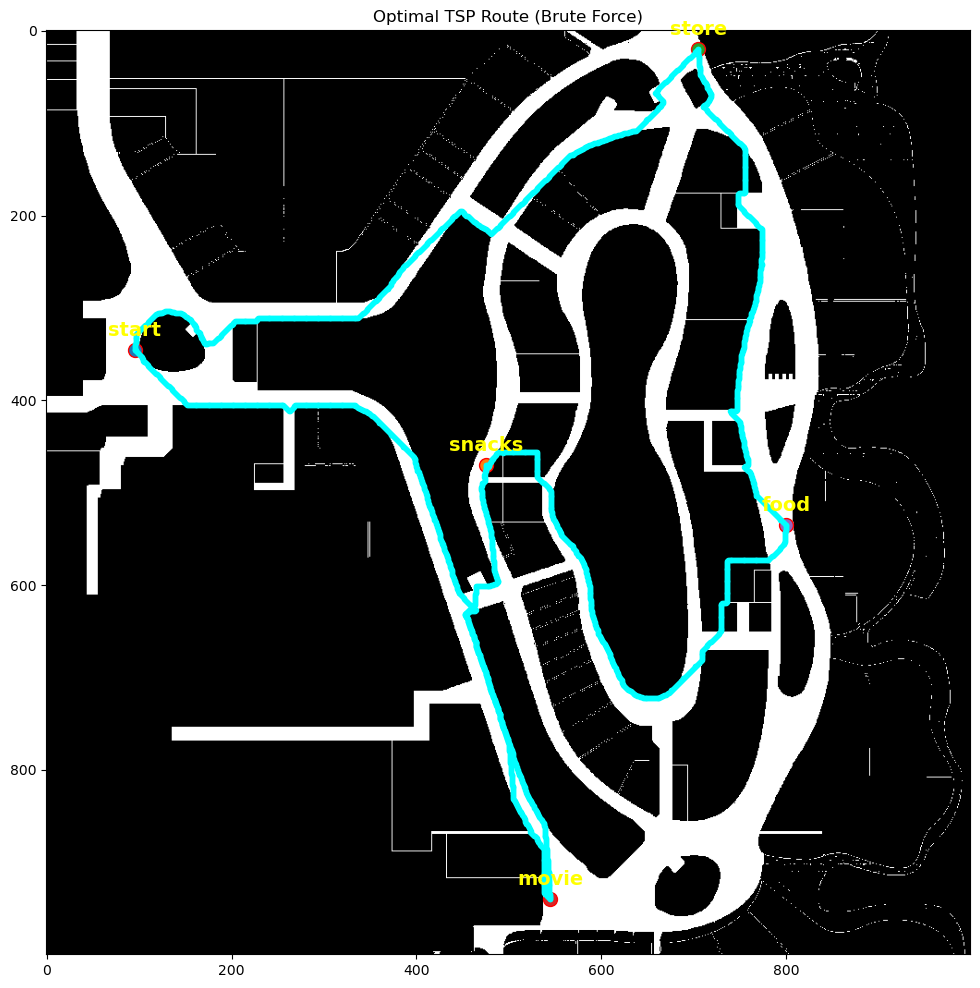


Summary of TSP Solutions:
Brute Force Optimal Route: ['start', 'movie', 'snacks', 'food', 'store', 'start'] with total distance: 145.05599999999984 meters
Greedy Route: ['start', 'snacks', 'store', 'food', 'movie', 'start'] with total distance: 153.1083999999997 meters


In [6]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import heapq
from math import sqrt
import time
import itertools
import pandas as pd

# ----------------------------
# 0. (Re)Load the Map and Key Locations (if not already loaded)
# ----------------------------
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()

MAP_RES = 0.2  # Each grid cell represents 0.2m x 0.2m

locations = {
    'start':  (345, 95),    # Level 2 Escalator (start)
    'snacks': (470, 475),   # Garrett Popcorn
    'store':  (20, 705),    # DJI Store
    'movie':  (940, 545),   # Golden Village
    'food':   (535, 800),   # PUTIEN
}

# ----------------------------
# 1. A* Algorithm Function (from Task 1)
# ----------------------------
def heuristic(a, b):
    """Heuristic function using Euclidean distance."""
    return sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def a_star(grid, start, goal):
    """
    A* path planning algorithm.
    
    Returns a dictionary containing:
      - 'path': The planned path (list of coordinates from start to goal)
      - 'total_distance': Total travel distance in meters
      - 'visited_cells': List of all grid cells visited during the search
      - 'run_time': Total run time of the algorithm (in seconds)
      - 'open_nodes': Number of nodes remaining in the open list at termination
      - 'closed_nodes': Number of nodes in the closed list (expanded nodes)
    """
    # 8-connected neighbors (8 directions)
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1)]
    
    open_list = []
    heapq.heappush(open_list, (heuristic(start, goal), 0, start))
    
    came_from = {}
    g_score = {start: 0}
    closed_list = set()
    visited_cells = []
    start_time = time.time()
    
    while open_list:
        _, current_g, current = heapq.heappop(open_list)
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            
            total_distance = 0
            for i in range(1, len(path)):
                dx = abs(path[i][0] - path[i-1][0])
                dy = abs(path[i][1] - path[i-1][1])
                total_distance += 0.282 if dx != 0 and dy != 0 else 0.2
            total_distance *= MAP_RES
            
            run_time = time.time() - start_time
            return {
                'path': path,
                'total_distance': total_distance,
                'visited_cells': visited_cells,
                'run_time': run_time,
                'open_nodes': len(open_list),
                'closed_nodes': len(closed_list)
            }
        
        closed_list.add(current)
        visited_cells.append(current)
        
        for dx, dy in neighbors:
            neighbor = (current[0] + dx, current[1] + dy)
            if (0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]
                    and grid[neighbor[0], neighbor[1]] == 255):
                if neighbor in closed_list:
                    continue
                tentative_g = current_g + (0.282 if dx != 0 and dy != 0 else 0.2)
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f = tentative_g + heuristic(neighbor, goal)
                    heapq.heappush(open_list, (f, tentative_g, neighbor))
                    
    return None  # Return None if no path is found

# ----------------------------
# 2. Compute the Distance Matrix Between Key Locations
# ----------------------------
location_keys = list(locations.keys())
dist_matrix = pd.DataFrame(np.zeros((len(location_keys), len(location_keys))),
                           index=location_keys, columns=location_keys)

# For each pair of key locations, compute the shortest path distance using A*
for i in range(len(location_keys)):
    for j in range(i+1, len(location_keys)):
        start_loc = locations[location_keys[i]]
        goal_loc = locations[location_keys[j]]
        result = a_star(grid_map, start_loc, goal_loc)
        if result is not None:
            d = result['total_distance']
            dist_matrix.loc[location_keys[i], location_keys[j]] = d
            dist_matrix.loc[location_keys[j], location_keys[i]] = d
        else:
            dist_matrix.loc[location_keys[i], location_keys[j]] = np.inf
            dist_matrix.loc[location_keys[j], location_keys[i]] = np.inf

print("Distance Matrix Between Key Locations (in meters):")
print(dist_matrix)

# ----------------------------
# 3. Solve the TSP Problem Using Two Methods
# ----------------------------

# Method 1: Brute Force (Exhaustive Search)
def tsp_brute_force(dist_matrix):
    nodes = list(dist_matrix.index)
    start = "start"
    others = [node for node in nodes if node != start]
    best_route = None
    best_distance = float("inf")
    for perm in itertools.permutations(others):
        route = [start] + list(perm) + [start]
        total = 0
        for k in range(len(route)-1):
            total += dist_matrix.loc[route[k], route[k+1]]
        if total < best_distance:
            best_distance = total
            best_route = route
    return best_route, best_distance

best_route_brute, best_distance_brute = tsp_brute_force(dist_matrix)
print("\nBrute Force Optimal Route:", best_route_brute)
print("Total Distance (Brute Force):", best_distance_brute, "meters")

# Method 2: Greedy Algorithm
def tsp_greedy(dist_matrix):
    nodes = list(dist_matrix.index)
    start = "start"
    current = start
    route = [start]
    remaining = set(nodes)
    remaining.remove(start)
    total = 0
    while remaining:
        next_node = min(remaining, key=lambda x: dist_matrix.loc[current, x])
        total += dist_matrix.loc[current, next_node]
        route.append(next_node)
        current = next_node
        remaining.remove(next_node)
    total += dist_matrix.loc[current, start]
    route.append(start)
    return route, total

route_greedy, total_greedy = tsp_greedy(dist_matrix)
print("\nGreedy Route:", route_greedy)
print("Total Distance (Greedy):", total_greedy, "meters")

# ----------------------------
# 4. Plot the Final Optimal Route on the Map (Brute Force Result)
# ----------------------------
def plot_tsp_route(route, grid, locations, title="Optimal TSP Route"):
    plt.figure(figsize=(12, 12))
    plt.imshow(grid, cmap='gray')
    # Plot key locations
    for key, value in locations.items():
        plt.plot(value[1], value[0], marker='o', markersize=10, markeredgecolor='red')
        plt.text(value[1], value[0]-15, s=key, fontsize=14, fontweight='bold', color='yellow', ha='center')
    
    # For each consecutive pair in the route, compute and plot the path segment using A*
    for i in range(len(route)-1):
        start_loc = locations[route[i]]
        goal_loc = locations[route[i+1]]
        result = a_star(grid, start_loc, goal_loc)
        if result is not None:
            path = result['path']
            path_x = [p[1] for p in path]
            path_y = [p[0] for p in path]
            plt.plot(path_x, path_y, marker='o', markersize=3, color='cyan')
    plt.title(title)
    plt.show()

# Plot the optimal route computed by the brute force method
plot_tsp_route(best_route_brute, grid_map, locations, title="Optimal TSP Route (Brute Force)")

# ----------------------------
# 5. Summary of Findings
# ----------------------------
print("\nSummary of TSP Solutions:")
print("Brute Force Optimal Route:", best_route_brute, "with total distance:", best_distance_brute, "meters")
print("Greedy Route:", route_greedy, "with total distance:", total_greedy, "meters")

